In [116]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functions import loaddata
from portfolio import Portfolio
from model import Fin_model
from financials import financials
from financials import fin_handlers
from sklearn.linear_model import LogisticRegression 
from sklearn.preprocessing import PolynomialFeatures
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Some note:

The date is in year month day format
ROWS = stocks
COLS = dates

In [7]:
data = {'asset_index': [0, 1, 2, 3],
        'holdings': [25, 30, 35, 45],
        'price': [24.5, 26, 27, 39.2],
        'position' : [1, 0, 0, 1]
        }
stock_data = pd.DataFrame(data)

pred = [1, 1, 1, 1]

diffs = stock_data[stock_data['position'] != pred]
print(diffs)

   asset_index  holdings  price  position
1            1        30   26.0         0
2            2        35   27.0         0


In [292]:
test = loaddata("mid_close", 20180101, 20200101)

In [281]:

asset_indices = [0, 1, 2, 3, 4]
assets = test.iloc[asset_indices].dropna(axis = 1)
num_assets = len(asset_indices)
# start_cap = 1000
# portfolio = Portfolio(asset_indices, start_cap)
print(assets.shape)


(5, 485)


In [138]:
residuals = financials.residual_returns(assets)
slice = residuals.iloc[:, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]
# print(slice.iloc[:, np.arange(slice.shape[1] - 1)])
feature_matrix = fin_handlers.create_features(slice, [financials.upper_boiler_band, financials.expo_moving_average, financials.lower_boiler_band, financials.signal_to_noise], labels = ["LB", "EXPO AVG", "UB", "SNR"])
print(feature_matrix)


           LB  EXPO AVG          UB          SNR  MOMENTUM
0 -164.229633 -1.673290 -170.428361 -1741.911005 -0.008056
1   -2.317385 -0.044866   -6.655886   -95.345727 -0.011445
2  117.087895  1.159332  114.778423  8694.449630 -0.003030
3   46.621733  0.454344   44.247129  3223.016173 -0.000721
4  -47.355126 -0.492721  -51.189158 -1340.756432  0.001329
5  -62.884940 -0.645205  -66.156012 -2412.000088  0.007960
6  209.068830  2.060778  203.086728  2303.474663 -0.007759


In [295]:

fin_functions = [financials.expo_moving_average, financials.signal_to_noise, financials.lower_boiler_band, financials.upper_boiler_band] #financials.signal_to_noise
model = Fin_model(LogisticRegression, fin_functions, feature_map = PolynomialFeatures)
Delta = 10
training_features, training_labels = model.get_sample_features(asset_indices, Delta, 15, assets)

In [296]:
#print(training_features)
model.train_with_feature_map(asset_indices, Delta, assets, 250)

#coefficients = model.model.coef_[0]
feature_names = ["LB", "EXPO AVG", "UB", "SNR"]

# Pair feature names with their corresponding coefficients
# feature_coefficients = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
# print(feature_coefficients)

doing some transformations!
Accuracy on training data: 0.8888


In [301]:
test_data = loaddata("mid_close", 20200101, 20210101)


In [302]:
test_data = test_data.iloc[asset_indices].dropna(axis = 1)
test_features, test_labels = model.get_sequential_features(asset_indices, Delta, test_data)
print(test_features.shape)

(1080, 4)


In [123]:
print(len(test_labels))
from sklearn.metrics import accuracy_score
preds = model.model.predict(test_features)
accuracy = accuracy_score(test_features, preds)

4796


ValueError: X has 5 features, but LogisticRegression is expecting 56 features as input.

Text(0.5, 1.0, 'Portfolio Value with FlipR Lite')

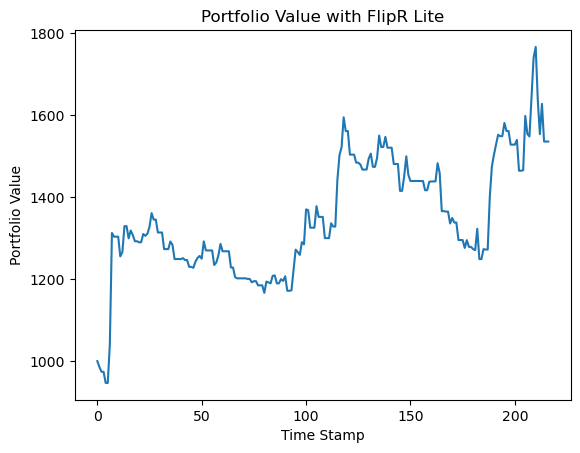

In [305]:
portfolio = Portfolio(asset_indices, 1000)
num_days = test_data.shape[1]
days = test_data.columns.tolist()
time_step = 1
day = 11
decision_data = pd.DataFrame()
decision_data["asset_index"] = asset_indices
values = []

while day < num_days - 1:
    
    #print(portfolio.value) # def predict(self, day, Delta, asset_indices, data_matrix):
    decision_data["price"] = test_data.loc[asset_indices, days[day]]
    preds = model.predict_with_feature_map(day, Delta, asset_indices, test_data)
    decision_data["position"] = preds
    portfolio.update(decision_data)
    day += time_step
    values.append(portfolio.value)

#print(portfolio.value) # def predict(self, day, Delta, asset_indices, data_matrix):
decision_data["price"] = test_data.loc[asset_indices, days[day]]
preds = 2 * np.ones(len(asset_indices))
decision_data["position"] = preds
portfolio.update(decision_data)
values.append(portfolio.value)
day += time_step


iters = np.arange(0, len(values))
plt.plot(iters, values)
plt.xlabel("Time Stamp", fontname = "Courier New")
plt.ylabel("Portfolio Value", fontname = "Courier New")
plt.title("Portfolio Value with FlipR Lite", fontname = "Courier New")

In [304]:
print(portfolio.value)
print((portfolio.value - 1000)/1000)


1535.0999026298518
0.5350999026298519
